In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import semopy

import matplotlib.pyplot as plt

from lingam import DirectLiNGAM
from lingam.utils import make_dot, remove_effect, calculate_total_effect, print_causal_directions, print_dagc
from lingam.bootstrap import BootstrapResult

import networkx as nx
import graphviz as gv
from IPython.display import display, Image, Markdown

np.random.seed(0)

## 準備

In [2]:
import requests

def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w") as f:
        f.write(res.text)

dirname = "ada_log_reg"
if os.path.isdir(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)

_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/_adaptive_logistic_regression.py", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/adaptive_logistic_regression.r", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/ada_logistic_reg/refs/heads/main/ada_logistic_reg/__init__.py", dirname=dirname)

from ada_log_reg import predict_adaptive_logistic_regression

## 関数

In [3]:
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils import check_array
from lingam.utils import remove_effect

def run_analysis(X, exog_var_names, endog_var_names, sink_var_name, cd_model=None, sink_model=None):
    """
    X : pandas.DataFrame
        型はfloatまたはintであること。intは離散変数と解釈する。
    exog_var_names : list of str
        外生変数と仮定する変数のリスト。
    endog_var_names : list of str
        内生変数のリスト。
    sink_var_name : str
        シンク変数のリスト
    cd_model : object
        LiNGAMのインスタンス。必要なら事前知識など登録しておく。
    sink_model : object
        シンク変数へのエッジ係数を算出する際に用いるモデル。例えばシンクが離散ならばLogisticRegressionやAdaptiveLogisticRegressionなど。
        AdaptiveLogisticRegressionはpipできないため、インスタンス作成をユーザに任せる。
    """
    # Xの確認
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X must be padnas.DataFrame.")
    
    # 変数名リストの確認
    if len(set(exog_var_names) - set(X.columns)) > 0:
        raise ValueError("exog_var_names includes unknown variables.")
       
    if len(set(endog_var_names) - set(X.columns)) > 0:
        raise ValueError("endog_var_names includes unknown variables.")
        
    if len(set([sink_var_name]) - set(X.columns)) > 0:
        raise ValueError("sink_var_name is unknown variables.")

    # cd_modelのチェック
    if cd_model is None:
        cd_model = DirectLiNGAM()
    else:
        if isinstance(cd_model, DirectLiNGAM):
            pass
        else:
            # 他のクラスは未対応
            raise ValueError("cd_model must be a instance of following classes: DirectLiNGAM, ")
    
    # sink_modelのチェックはしない。
    
    # Xの処理
    exog_indices = [X.columns.tolist().index(v) for v in exog_var_names]
    endog_indices = [X.columns.tolist().index(v) for v in endog_var_names]
    sink_index = X.columns.tolist().index(sink_var_name)
    
    is_discrete = X.dtypes == int
    if is_discrete[endog_indices].any():
        raise ValueError("endog_var_names mustn't be a discrete variable. Convert types of variables specified in endog_var_names.")
    
    names = X.columns.tolist()
    
    X = check_array(X, copy=True)
    
    if sink_model is None:
        if is_discrete[sink_index]:
            sink_model = LogisticRegression()
        else:
            sink_model = LinearRegression()
    
    # 因果探索
    X_removed_exog = remove_effect(X, exog_indices)
    X_endog = X_removed_exog[:, endog_indices]
    
    cd_model.fit(X_endog)
    
    # シンク変数のモデル
    sink_model.fit(X[:, endog_indices], X[:, sink_index])
    sink_coef = sink_model.coef_

    # 隣接行列の作成
    adj = np.concatenate([cd_model.adjacency_matrix_, sink_coef])
    adj = np.concatenate([adj, np.zeros((len(adj), 1))], axis=1)

    cols = [names[i] for i in [*endog_indices, sink_index]]
    adj = pd.DataFrame(adj, columns=cols, index=cols)
    
    return adj

### データ生成関数
いくつかの外生変数を持ち、シンクがひとつであること。また外生変数は離散と連続が混在で、シンクは離散であること。

In [4]:
def _make_adj_mat(n_vars=10, n_exogs=3, sparse_ratio=0.8, no_direct_edge=True):
    """ このノートブックでのみ使用
    
    Parameters
    ----------
    n_vars : int
        変数の数
    n_exog : int
        外生変数の数
    sparse_ratio : bool
        係数がゼロになる割合。
    no_direct_edge : bool
        exogとsinkが直接のエッジを持たない。
        
    Return
    ------
    B : pandas.DataFrame
        隣接行列。先頭n_exog行が外生変数、最下行がシンク変数
    """
    n_sink = 1
    
    def _sort_adj(adj):
        ordered_indices = list(nx.topological_sort(
            nx.from_numpy_array(adj.T, create_using=nx.DiGraph)
        ))
        return adj[ordered_indices][:, ordered_indices]
    
    # 適当に隣接行列を作成
    B = np.random.uniform(0.5, 1.5, size=(n_vars, n_vars))
    B *= np.random.choice([-1, 1], size=(n_vars, n_vars))
    B *= np.tril(B, k=-1)

    # スパースにする
    mask = np.random.choice([0, 1], p=[sparse_ratio, 1- sparse_ratio], size=(n_vars, n_vars))
    B *= mask
    
    # 因果順序を調べて並び替え。後の処理が楽になる。
    B = _sort_adj(B)
    
    # 外生変数の数を調整
    is_exog = np.isclose(B, 0).all(axis=1)
    n_sub = is_exog.sum() - n_exogs
    
    if n_sub < 0:
        # 外生変数が足りないならば増やす
        B[:n_exogs] = 0
    elif n_sub > 0:
        # 外生変数が多すぎるならば内生変数化する。
        targets = np.argwhere(is_exog).ravel()[n_exogs:n_exogs + n_sub]
        for target in targets:
            # 対角より右にはみ出ないように。
            coef = np.random.uniform(0.5, 1.5, size=target) * np.random.choice([-1, 1], size=target)
            
            # スパースにする
            mask = np.random.choice([0, 1], p=[sparse_ratio, 1- sparse_ratio], size=target)
            
            # 外生化は防ぐ
            if sum(mask) == 0:
                mask[np.random.choice(np.arange(target))] = 1
                
            B[target, :target] = coef * mask
    
    # 再び因果順序を調べて並び替え。後の処理が楽になる。
    B = _sort_adj(B)
    
    #display(pd.DataFrame(B))
    
    # シンクの数を調整
    is_sink = np.isclose(B, 0).all(axis=0)
    
    n_delete = sum(is_sink) - n_sink
    if n_delete > 0:
        # 一番最後のシンク以外は子をもたせる
        targets = np.argwhere(is_sink).ravel()[:-1]
        
        for target in targets:
            # 対角より上にはみ出ないように。
            n_coef = n_vars - target - 1
            
            # 外生変数に係数を与えないように。
            if n_vars - n_coef < n_exogs:
                n_coef = n_vars - n_exogs

            coef = np.random.uniform(0.5, 1.5, size=n_coef) * np.random.choice([-1, 1], size=n_coef)
            
            mask = np.random.choice([0, 1], p=[sparse_ratio, 1- sparse_ratio], size=n_coef)
            
            # シンク化は防ぐ
            if sum(mask) == 0:
                mask[np.random.choice(np.arange(n_coef))] = 1
            
            B[-n_coef:, target] = coef * mask
        
    # 一応並び替え
    B = _sort_adj(B)
    
    if True:
        # 最後の行が外生を親に持たないように
        if no_direct_edge:
            indices = np.argwhere(~np.isclose(B[-1, :n_exogs], 0))
            #print(indices)
            for index in indices:
                # 対角以下&外生以下のどこかに移動。外生変数の孤立を防ぐため。
                to = np.random.choice(np.arange(max(index + 1, n_exogs), n_vars))
                B[to, index] = B[-1, index]
                B[-1, index] = 0
    #display(pd.DataFrame(B))

    # +-0が出てくるので消す。
    B[np.isclose(B, 0)] = 0

    var_names = [f"x{i}" for i in range(n_vars)]
    B = pd.DataFrame(B, columns=var_names, index=var_names)
    
    return B

#np.random.seed(0)
#for i in range(100):
#    tmp = _make_adj_mat(n_vars=20, n_exogs=5, sparse_ratio=0.5).iloc[-1, :5].values

if True:
    # 動作確認用
    n_exogs = []
    n_sinks = []
    for i in range(1000):
        np.random.seed(i)

        B = _make_adj_mat(sparse_ratio=np.random.uniform())

        # 外生の数
        n_exog = np.isclose(B, 0).all(axis=1).sum()
        n_exogs.append(n_exog)

        # シンクの数
        n_sink = np.isclose(B.T, 0).all(axis=1).sum()
        n_sinks.append(n_sink)

    print("n_exog:", np.unique(n_exogs, return_counts=True))
    print("n_sink", np.unique(n_sinks, return_counts=True))

n_exog: (array([3]), array([1000]))
n_sink (array([1, 2]), array([994,   6]))


### 可視化関数

In [5]:
def _draw(adj, exog_var_names, endog_var_names, sink_var_name):
    """ このノートブックでのみ使用 """
    g = gv.Digraph()

    cluster_names = ["control", "endogenous", "target"]
    
    # ノード作成
    for cluster_name, var_names in zip(cluster_names, [exog_var_names, endog_var_names, [sink_var_name]]):
        with g.subgraph(name=f"cluster_{cluster_name}") as sub:
            for var_name in var_names:
                sub.node(var_name, var_name)
            sub.attr(label=f"{cluster_name}")
            
    # エッジ作成
    for to_name, coefs in adj.iterrows():
        for from_name, coef in coefs.items():
            if np.isclose(coef, 0):
                continue
            g.edge(from_name, to_name, label=f"{coef:.2f}")
            
    return g

if False:
    B = _make_adj_mat()
    display(B)

    exog_var_names = B.columns[np.isclose(B, 0).all(axis=1)].tolist()
    sink_var_name = B.columns[np.isclose(B, 0).all(axis=0)][0]
    endog_var_names =  sorted(set(B.columns) - set(exog_var_names) - set([sink_var_name]))
    _draw(B, exog_var_names, endog_var_names, sink_var_name)

## 実験

### 因果グラフの生成

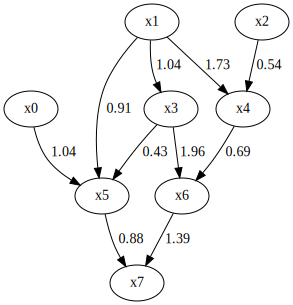

In [6]:
# no_direct_edgeはシンクと外生の間に直接エッジを持たせないオプション
n_vars = 8
n_exogs = 3

B = _make_adj_mat(n_vars=n_vars, n_exogs=n_exogs, sparse_ratio=0.80, no_direct_edge=True)

make_dot(B)

### 変数のグループ分け

,x0,x1,x2,x3,x4,x5,x6,x7
x0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
x1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
x2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
x3,0.00000,1.043033,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
x4,0.00000,1.727876,0.537213,0.000000,0.000000,0.000000,0.00000,0.0
x5,1.04173,0.911644,0.000000,0.427535,0.000000,0.000000,0.00000,0.0
x6,0.00000,0.000000,0.000000,1.960631,0.691463,0.000000,0.00000,0.0
x7,0.00000,0.000000,0.000000,0.000000,0.000000,0.883435,1.38536,0.0


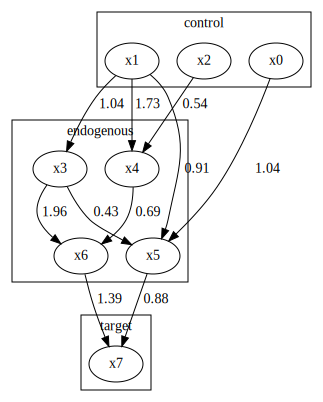

In [7]:
exog_var_names = [f"x{i}" for i in range(n_exogs)]
endog_var_names = [f"x{i}" for i in range(n_exogs, n_vars - 1)]
sink_var_name = f"x{n_vars - 1}"

display(B)

_draw(B, exog_var_names, endog_var_names, sink_var_name)

#### データの生成

x2とx9を離散にする。因果グラフは因果順序で並べてあるので、上から作っていけばよい。

,x0,x1,x2,x3,x4,x5,x6,x7
0,-1.178740,1,0.604687,0.591586,0.770364,-0.586747,2.362159,1
1,-0.283088,0,0.423684,0.131325,0.618378,0.535474,0.247910,1
2,-1.343754,0,-0.829340,-1.438184,0.923252,-3.188344,-1.409670,0
3,0.477684,0,-0.136777,-0.668422,1.261693,0.205320,-1.319106,0
4,-1.512870,0,-0.668269,1.039409,-0.479267,-2.588315,1.186431,0
...,...,...,...,...,...,...,...,...
995,-0.286691,0,-0.461588,-1.348441,0.005724,-1.929926,-1.058320,0
996,0.300882,1,-1.593612,0.170889,-0.726790,0.711700,1.463660,1
997,-1.489866,1,0.991241,-0.644371,2.460237,-0.757618,1.527715,0
998,-1.178129,1,0.214358,-0.185746,1.410313,-0.879703,-0.935233,0


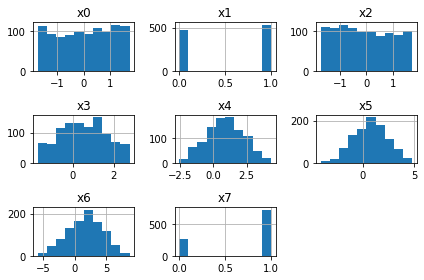

In [8]:
n_sample = 1000
#is_discrete = [False, False, True, False, False, False, False, False, False, True]

is_discrete = [
    # controlは半分くらい離散
    *np.random.choice([False, True], size=len(exog_var_names)),
    # endogenousはすべて連続
    *[False for _ in range(len(endog_var_names))],
    # targetは離散
    True,
]

X = np.zeros((len(B), n_sample))

for i, (name, coefs) in enumerate(B.iterrows()):
    if not is_discrete[i]:
        X[i] = coefs @ X + np.random.uniform(-1.732, 1.732, size=n_sample)
    else:
        X[i] = expit(coefs @ X) >= np.random.uniform(size=n_sample)
        
X = pd.DataFrame(X.T, columns=B.columns)
for c, d in zip(X.columns, is_discrete):
    X[c] = X[c].astype(int if d else float)

display(X)

X.hist()
plt.tight_layout()
plt.show()

### 分析の実行

In [9]:
class Wrapper:
    """ AdaptiveLogisticRegression用 """
    
    def fit(self, X, y):
        # 一度くっつける。そのうえで説明変数と目的変数のインデックスを取る。
        X_ = np.concatenate([X, y.reshape(-1, 1)], axis=1)
        
        predictors = np.arange(len(X.T))
        target = X_.shape[1] - 1
        
        coef = predict_adaptive_logistic_regression(X_, predictors, target)
        
        self.coef_ = coef

pred = run_analysis(X, exog_var_names, endog_var_names, sink_var_name, cd_model=None, sink_model=Wrapper())
true = B.iloc[len(exog_var_names):, len(exog_var_names):]

display(Markdown("#### 予測結果"))
display(pred)

display(Markdown("#### 正解"))
display(true)

#### 予測結果

,x3,x4,x5,x6,x7
x3,0.000000,0.00000,0.000000,0.000000,0.0
x4,0.000000,0.00000,0.000000,0.000000,0.0
x5,0.453852,0.00000,0.000000,0.000000,0.0
x6,1.924244,0.65002,0.000000,0.000000,0.0
x7,0.000000,0.00000,0.948077,1.216103,0.0


#### 正解

,x3,x4,x5,x6,x7
x3,0.000000,0.000000,0.000000,0.00000,0.0
x4,0.000000,0.000000,0.000000,0.00000,0.0
x5,0.427535,0.000000,0.000000,0.00000,0.0
x6,1.960631,0.691463,0.000000,0.00000,0.0
x7,0.000000,0.000000,0.883435,1.38536,0.0


## 適合度評価

semopyを使用した。

In [10]:
def calc_fit_indices(B, X):
    desc = ""
    for name, row in B.iterrows():
        var_model = []
        
        for name2, coef in row.items():
            if np.isclose(coef, 0):
                continue
            var_model.append(f"{coef} * {name2}")
        
        if len(var_model) == 0:
            continue
        
        var_model = f"{name} ~ " + " + ".join(var_model) + "\n"
        desc += var_model
    
    m = semopy.Model(desc)
    m.fit(X)
    stats = semopy.calc_stats(m)
    
    return stats
    
calc_fit_indices(B, X)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,31,31,5318.067417,0.0,4862.463589,-0.094299,-0.093698,-0.093698,-0.093698,-0.094299,0.413184,-0.636135,23.902642,5.318067


## ブートストラップ

### 実行

In [11]:
n_sampling = 100

target_vars = [*endog_var_names, sink_var_name]

adjs = np.zeros((n_sampling, len(target_vars), len(target_vars)))
total_effects = np.zeros((n_sampling, len(target_vars), len(target_vars)))
fit_indices_df = []

for i in range(n_sampling):
    print("\r", i, end="")
    
    X_resampled = resample(X)
    
    # 因果探索
    adj = run_analysis(X_resampled, exog_var_names, endog_var_names, sink_var_name, cd_model=None, sink_model=Wrapper())
    adjs[i] = adj

    # 因果順序
    dag = nx.from_numpy_array(adj.values.T, create_using=nx.DiGraph)
    causal_order = list(nx.topological_sort(dag))

    # https://github.com/cdt15/lingam/blob/master/lingam/bootstrap.py#L52
    for c, from_ in enumerate(causal_order):
        for to in causal_order[c + 1 :]:
            total_effects[i, to, from_] = calculate_total_effect(
                adj.values, from_, to
            )
    
    # リサンプルしたデータに対する適合度計算。
    # XXX: リサンプル前の元データの方がいい？
    fit_indices = calc_fit_indices(adj, X_resampled)
    fit_indices_df.append(fit_indices)
print("\r\n")
            
result = BootstrapResult(adjs, total_effects)
fit_indices_df = pd.concat(fit_indices_df)

 99



### 結果

In [12]:
# https://github.com/cdt15/lingam/blob/master/examples/Bootstrap.ipynb

display(Markdown("### Causal Directions"))
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, n_sampling)

display(Markdown("### Directed Acyclic Graphs"))
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling)

display(Markdown("### Probability"))
prob = result.get_probabilities(min_causal_effect=0.01)
print(prob)

display(Markdown("### Total Causal Effects"))
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

# Assign to pandas.DataFrame for pretty display
df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
display(df)

# XXX: 外生変数が隣接行列にないため、外生変数からの効果は算出不可
# おそらく仕様が変更されるが、いまは外生変数がないため、その分をindexから引き抜いておく。
from_index = 3 - len(exog_var_names) # x3
to_index = 7 - len(exog_var_names) # x7
display(Markdown(f"### Bootstrap Probability of Path (x{from_index}→x{to_index})"))
pd.DataFrame(result.get_paths(from_index, to_index))

### Causal Directions

x2 <--- x0 (b>0) (100.0%)
x3 <--- x0 (b>0) (100.0%)
x3 <--- x1 (b>0) (100.0%)
x4 <--- x2 (b>0) (100.0%)
x4 <--- x3 (b>0) (100.0%)
x4 <--- x1 (b>0) (16.0%)
x2 <--- x3 (b>0) (6.0%)
x2 <--- x1 (b<0) (3.0%)


### Directed Acyclic Graphs

DAG[0]: 73.0%
	x2 <--- x0 (b>0)
	x3 <--- x0 (b>0)
	x3 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
DAG[1]: 12.0%
	x2 <--- x0 (b>0)
	x3 <--- x0 (b>0)
	x3 <--- x1 (b>0)
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
DAG[2]: 4.0%
	x2 <--- x0 (b>0)
	x2 <--- x3 (b>0)
	x3 <--- x0 (b>0)
	x3 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)


### Probability

[[0.   0.01 0.   0.   0.  ]
 [0.01 0.   0.01 0.   0.  ]
 [1.   0.03 0.   0.06 0.  ]
 [1.   1.   0.03 0.   0.  ]
 [0.01 0.16 1.   1.   0.  ]]


### Total Causal Effects

,from,to,effect,probability
0,x0,x2,0.451586,1.00
1,x0,x3,1.928760,1.00
2,x1,x3,0.661175,1.00
3,x0,x4,2.802792,1.00
4,x1,x4,0.827722,1.00
5,x2,x4,0.989316,1.00
6,x3,x4,1.235408,1.00
7,x1,x2,0.038902,0.10
8,x3,x2,0.064972,0.06
9,x2,x3,0.082886,0.04


### Bootstrap Probability of Path (x0→x4)

,path,effect,probability
0,"[0, 2, 4]",0.435445,1.00
1,"[0, 3, 4]",2.370661,1.00
2,"[0, 3, 2, 4]",0.131560,0.06
3,"[0, 2, 3, 4]",0.044577,0.03
4,"[0, 1, 3, 4]",-0.092321,0.01
5,"[0, 2, 1, 3, 4]",0.024740,0.01
6,"[0, 4]",0.804608,0.01


### 各ブートストラップ結果の適合度

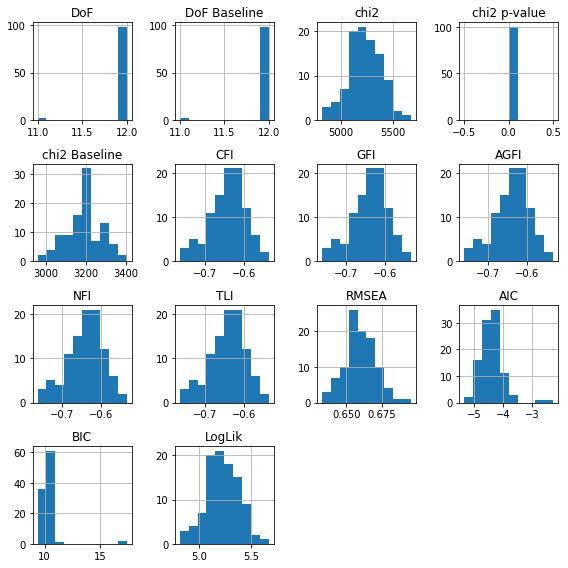

In [13]:
fit_indices_df.hist(figsize=(8, 8))
plt.tight_layout()
plt.show()

自由度でAICやBICの数値が変わりそうなので自由度別に見る。

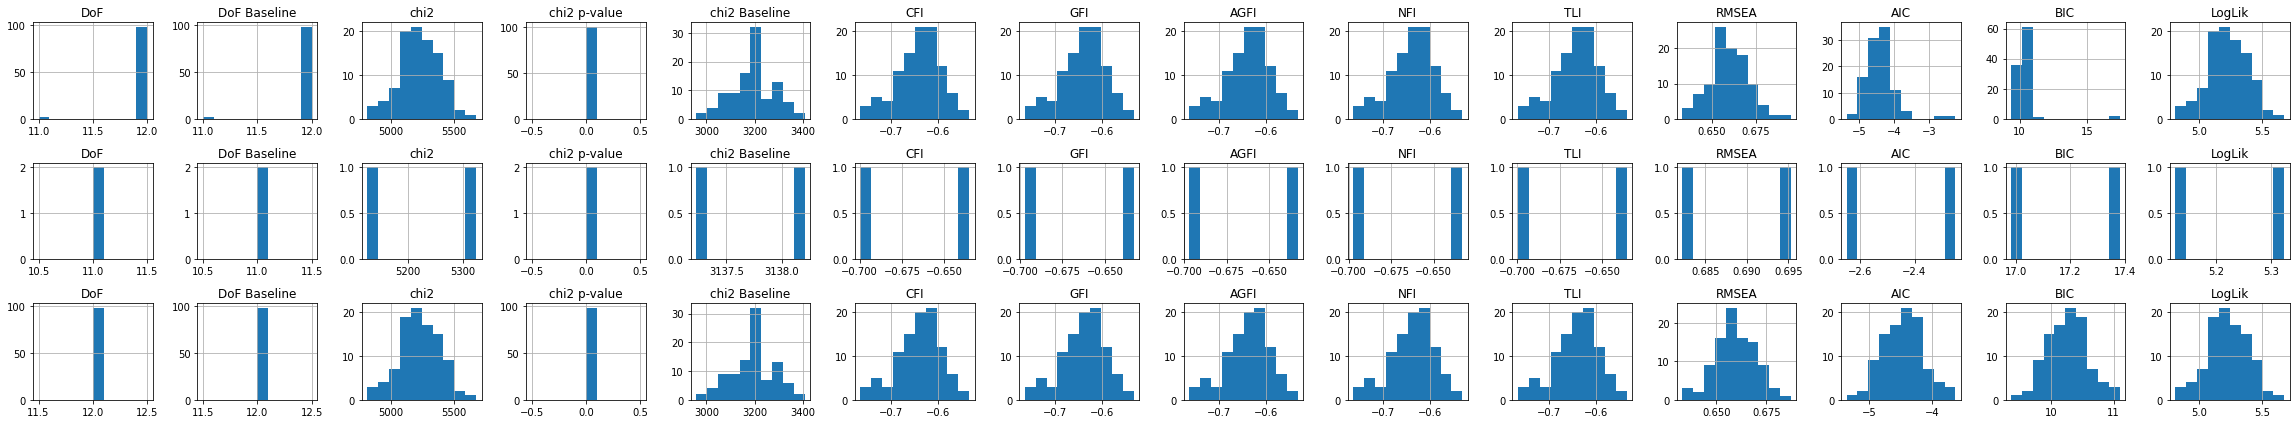

In [14]:
dofs = np.unique(fit_indices_df["DoF"])

fig, axes = plt.subplots(len(dofs) + 1, fit_indices_df.shape[1], figsize=(32, 2 * (len(dofs) + 1)))

fit_indices_df.hist(ax=axes[0])
for i, dof in enumerate(dofs):
    fit_indices_df[fit_indices_df["DoF"] == dof].hist(ax=axes[i + 1])

plt.tight_layout()
plt.show()